In [ ]:
reInstall = False

if reInstall == True :
    # Installe PyTorch pour CPU
    !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    # Installe NumPy et tqdm si nécessaire
    !pip install numpy tqdm scikit-learn matplotlib
    !clear
    print("Installation terminée")
    import torch
    import numpy as np
    from tqdm import tqdm

    print("torch:", torch.__version__)
    print("numpy:", np.__version__)


In [26]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

# utilise le CPU
device = torch.device("cpu")
print(f"🔧 Appareil utilisé : {device}")

🔧 Appareil utilisé : cpu


In [27]:
class LuSNARDataset(Dataset):
    def __init__(self, folder_path):
        self.files = sorted([f for f in os.listdir(folder_path) if f.endswith(".npz")])
        self.folder_path = folder_path

        # dictionnaire de remapping : -1 → 0, 0 → 1, 174 → 2
        self.label_map = { -1: 0, 0: 1, 174: 2 }

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder_path, self.files[idx])
        data = np.load(file_path)
        
        points = data["lidar_points"]        # (N, 3)
        labels = data["lidar_category"]      # (N,)

        num_points = 1024
        if len(points) >= num_points:
            indices = np.random.choice(len(points), num_points, replace=False)
        else:
            indices = np.random.choice(len(points), num_points, replace=True)
        
        pts = points[indices]
        lbl_raw = labels[indices]

        # application du mapping
        lbl = np.vectorize(self.label_map.get)(lbl_raw)

        return torch.tensor(pts, dtype=torch.float32), torch.tensor(lbl, dtype=torch.long)


In [28]:
dataset_path = "data/moon"  # à adapter si besoin
batch_size = 16

full_dataset = LuSNARDataset(dataset_path)

val_ratio = 0.1
test_ratio = 0.1

total_size = len(full_dataset)
val_size = int(val_ratio * total_size)
test_size = int(test_ratio * total_size)
train_size = total_size - val_size - test_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # pour reproductibilité
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [29]:
class TNet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        batchsize = x.size(0)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2)[0]

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.eye(self.k, device=x.device).view(1, self.k * self.k).repeat(batchsize, 1)
        x = x + iden
        return x.view(-1, self.k, self.k)


In [ ]:
class PointNetSeg(nn.Module):
    def __init__(self, num_classes=3):  # regolith, rock, crater
        super().__init__()
        self.input_transform = TNet(k=3)

        self.conv1 = nn.Conv1d(3, 64, 1)
        self.bn1 = nn.BatchNorm1d(64)

        self.conv2 = nn.Conv1d(64, 128, 1)
        self.bn2 = nn.BatchNorm1d(128)

        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.bn3 = nn.BatchNorm1d(1024)

        self.conv4 = nn.Conv1d(1088, 512, 1)
        self.bn4 = nn.BatchNorm1d(512)

        self.conv5 = nn.Conv1d(512, 256, 1)
        self.bn5 = nn.BatchNorm1d(256)

        self.dropout = nn.Dropout(p=0.3)
        self.conv6 = nn.Conv1d(256, num_classes, 1)

    def forward(self, x):
        B, N, _ = x.size()
        x = x.transpose(2, 1)  # (B, 3, N)

        # Input transform
        T = self.input_transform(x)
        x = torch.bmm(T, x)

        x = F.relu(self.bn1(self.conv1(x)))         # (B, 64, N)
        pointfeat = x                               # 🔧 on garde ce feature local
        x = F.relu(self.bn2(self.conv2(x)))         # (B, 128, N)
        x = F.relu(self.bn3(self.conv3(x)))         # (B, 1024, N)

        global_feat = torch.max(x, 2, keepdim=True)[0]  # (B, 1024, 1)
        global_feat = global_feat.repeat(1, 1, N)       # (B, 1024, N)

        x = torch.cat([pointfeat, global_feat], 1)      # (B, 64 + 1024 = 1088, N)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        x = self.conv6(x)                               # (B, num_classes, N)

        return x.transpose(2, 1).contiguous()           # (B, N, num_classes)



In [39]:

reCalculer = False

if reCalculer == True:
    from collections import Counter

    # ➤ calcul des poids de classe à partir du train_loader
    print("⏳ Calcul des poids de classes...")
    total_labels = []
    for _, labels in train_loader:
        total_labels.extend(labels.view(-1).tolist())

    counts = Counter(total_labels)
    print("📊 Répartition dans le train :", counts)

    num_classes = 3
    total = sum(counts.values())
    weights = torch.tensor([1 / counts[i] for i in range(num_classes)], dtype=torch.float32)
    weights = weights / weights.sum()  # normalisation

    # ➤ loss avec pondération
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))
    model = PointNetSeg(num_classes=3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
else:
    print("⏳ Calcul des poids de classes...")
    print("📊 Répartition dans le train : Counter({0: 3404410, 2: 454159, 1: 57207})")
    counts = Counter({0: 3404410, 2: 454159, 1: 57207})

⏳ Calcul des poids de classes...
📊 Répartition dans le train : Counter({0: 3404410, 2: 454159, 1: 57207})


In [44]:
import copy

num_epochs = 30
best_miou = 0.0
patience = 5
patience_counter = 0
SAVE_PATH = "pointnet_best_miou.pt"

best_model = None

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for points, labels in tqdm(train_loader, desc=f"🧪 Epoch {epoch} [train]"):
        points, labels = points.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(points)

        loss = criterion(outputs.view(-1, 3), labels.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # 🧪 Validation + mIoU
    model.eval()
    val_loss = 0
    correct = total = 0
    preds_all, labels_all = [], []

    with torch.no_grad():
        for points, labels in val_loader:
            points, labels = points.to(device), labels.to(device)
            outputs = model(points)

            val_loss += criterion(outputs.view(-1, 3), labels.view(-1)).item()
            preds = outputs.argmax(dim=2)

            correct += (preds == labels).sum().item()
            total += labels.numel()

            preds_all.append(preds.cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct / total

    # 🔍 mIoU
    y_true = np.concatenate(labels_all).flatten()
    y_pred = np.concatenate(preds_all).flatten()

    ious = []
    for cls in range(3):
        tp = np.logical_and(y_pred == cls, y_true == cls).sum()
        fp = np.logical_and(y_pred == cls, y_true != cls).sum()
        fn = np.logical_and(y_pred != cls, y_true == cls).sum()
        denom = tp + fp + fn
        iou = tp / denom if denom != 0 else float("nan")
        ious.append(iou)

    val_miou = np.nanmean(ious)

    print(f"📊 Epoch {epoch}: train loss={avg_train_loss:.4f} | val loss={avg_val_loss:.4f} | val acc={val_acc:.2f}% | val mIoU={val_miou:.4f}")

    # ✅ early stopping & checkpoint
    if val_miou > best_miou:
        best_miou = val_miou
        best_model = copy.deepcopy(model.state_dict())
        torch.save(best_model, SAVE_PATH)
        print(f"💾 Nouveau meilleur modèle sauvegardé (val mIoU: {best_miou:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break


🧪 Epoch 1 [train]: 100%|██████████| 239/239 [02:27<00:00,  1.62it/s]


📊 Epoch 1: train loss=0.2234 | val loss=0.1879 | val acc=89.52% | val mIoU=0.6851
💾 Nouveau meilleur modèle sauvegardé (val mIoU: 0.6851)


🧪 Epoch 2 [train]: 100%|██████████| 239/239 [02:41<00:00,  1.48it/s]


📊 Epoch 2: train loss=0.2214 | val loss=0.1898 | val acc=88.18% | val mIoU=0.6487


🧪 Epoch 3 [train]: 100%|██████████| 239/239 [02:41<00:00,  1.48it/s]


📊 Epoch 3: train loss=0.2209 | val loss=0.1936 | val acc=88.85% | val mIoU=0.6675


🧪 Epoch 4 [train]: 100%|██████████| 239/239 [06:19<00:00,  1.59s/it]


📊 Epoch 4: train loss=0.2218 | val loss=0.1869 | val acc=88.76% | val mIoU=0.6472


🧪 Epoch 5 [train]: 100%|██████████| 239/239 [02:34<00:00,  1.55it/s]


📊 Epoch 5: train loss=0.2259 | val loss=0.1871 | val acc=89.58% | val mIoU=0.6715


🧪 Epoch 6 [train]: 100%|██████████| 239/239 [02:38<00:00,  1.51it/s]


📊 Epoch 6: train loss=0.2277 | val loss=0.1803 | val acc=90.39% | val mIoU=0.6751
⏹️ Early stopping triggered.


In [48]:
SAVE_PATH = "pointnet_lusnar.pt"
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Modèle sauvegardé dans : {SAVE_PATH}")

# ---------------------------------------------------------------------------

model = PointNetSeg(num_classes=3).to(device)
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()
print("📦 Modèle chargé depuis :", SAVE_PATH)


✅ Modèle sauvegardé dans : pointnet_lusnar.pt
📦 Modèle chargé depuis : pointnet_lusnar.pt


🔍 Rapport par classe :
              precision    recall  f1-score   support

    regolith     0.9813    0.9087    0.9436    425563
      crater     0.5885    0.9982    0.7405      7081
        rock     0.5898    0.8651    0.7014     56828

    accuracy                         0.9049    489472
   macro avg     0.7198    0.9240    0.7951    489472
weighted avg     0.9301    0.9049    0.9125    489472

📊 IoU par classe :
 - regolith   : 0.8932
 - crater     : 0.5879
 - rock       : 0.5401

📈 mIoU global : 0.6737


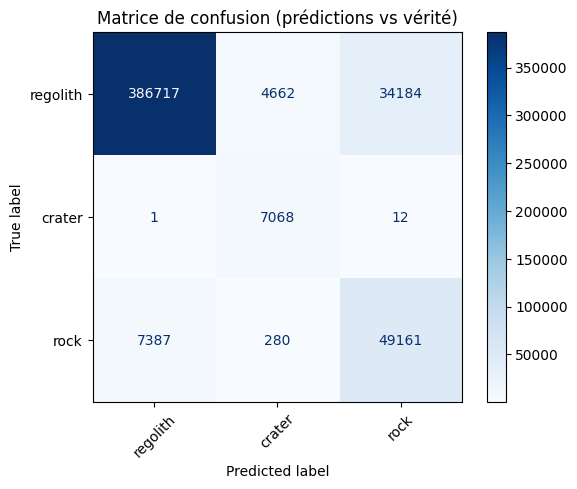

In [49]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# noms lisibles des classes
CLASS_NAMES = ["regolith", "crater", "rock"]

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        outputs = model(points)  # (B, N, C)
        preds = outputs.argmax(dim=2)  # (B, N)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# flatten all to 1D
y_true = np.concatenate(all_labels).flatten()
y_pred = np.concatenate(all_preds).flatten()

# 🔍 Rapport complet
print("🔍 Rapport par classe :")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# 🧮 Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap="Blues", xticks_rotation=45)
disp.ax_.set_title("Matrice de confusion (prédictions vs vérité)")
#plt.show()

# 🧠 mIoU manuel
ious = []
for cls in range(len(CLASS_NAMES)):
    tp = np.logical_and(y_pred == cls, y_true == cls).sum()
    fp = np.logical_and(y_pred == cls, y_true != cls).sum()
    fn = np.logical_and(y_pred != cls, y_true == cls).sum()
    denom = tp + fp + fn
    iou = tp / denom if denom != 0 else float("nan")
    ious.append(iou)

print("📊 IoU par classe :")
for cls, iou in zip(CLASS_NAMES, ious):
    print(f" - {cls:10s} : {iou:.4f}")

print(f"\n📈 mIoU global : {np.nanmean(ious):.4f}")


c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128998 (\N{LARGE BLUE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


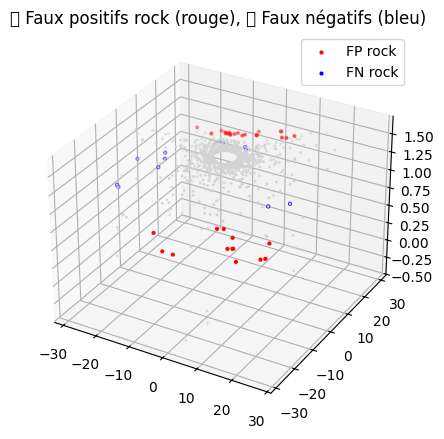

In [50]:
# ➤ chargement du meilleur modèle
model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

# ➤ exemple d’erreurs typiques : afficher faux positifs rock
for points, labels in test_loader:
    points, labels = points.to(device), labels.to(device)
    outputs = model(points)
    preds = outputs.argmax(dim=2)
    break  # on prend juste le premier batch

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

i = 0  # premier exemple du batch
pc = points[i].cpu().numpy()
true = labels[i].cpu().numpy()
pred = preds[i].cpu().numpy()

mask_fp_rock = (pred == 2) & (true != 2)
mask_fn_rock = (pred != 2) & (true == 2)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_title("🟥 Faux positifs rock (rouge), 🟦 Faux négatifs (bleu)")

ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c="lightgray", s=1)
ax.scatter(pc[mask_fp_rock, 0], pc[mask_fp_rock, 1], pc[mask_fp_rock, 2], c="red", s=4, label="FP rock")
ax.scatter(pc[mask_fn_rock, 0], pc[mask_fn_rock, 1], pc[mask_fn_rock, 2], c="blue", s=4, label="FN rock")
ax.legend()
plt.show()


In [51]:
model.eval()
correct = total = 0

with torch.no_grad():
    for points, labels in test_loader:
        points, labels = points.to(device), labels.to(device)
        outputs = model(points)
        preds = outputs.argmax(dim=2)

        correct += (preds == labels).sum().item()
        total += labels.numel()

acc = 100 * correct / total
print(f"🎯 Accuracy totale (point-wise) : {acc:.2f}%")


🎯 Accuracy totale (point-wise) : 90.41%


C:\Users\theog\AppData\Local\Temp\ipykernel_18488\38495407.py:35: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\theog\AppData\Local\Temp\ipykernel_18488\38495407.py:35: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129001 (\N{LARGE GREEN SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\theog\Nouveau dossier\Polytechnique\Research\research-code\point-transformer\point_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128311 (\N{LARGE BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


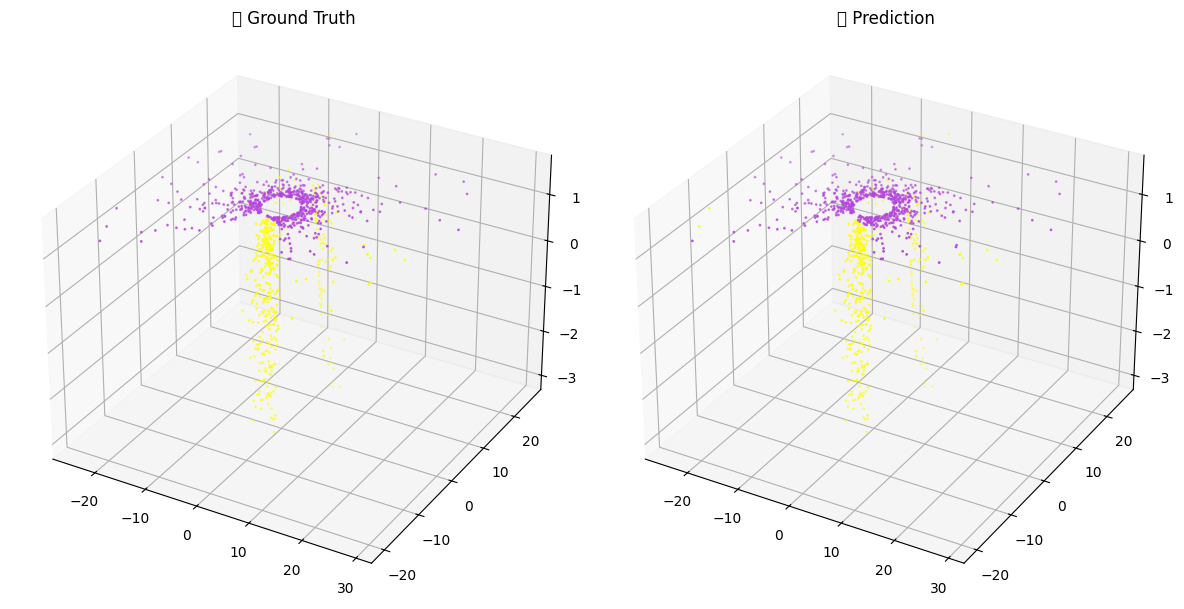

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# couleurs simples par classe
colors = np.array([
    [180, 70, 220],    # regolith - classe 0
    [0, 180, 255],     # crater - classe 1
    [255, 255, 0],     # rock - classe 2
]) / 255.0

# prendre un batch
points, labels = next(iter(test_loader))
points, labels = points.to(device), labels.to(device)
outputs = model(points)
preds = outputs.argmax(dim=2)  # (B, N)

# prendre le premier échantillon du batch
i = 5
pc = points[i].cpu().numpy()        # (N, 3)
gt = labels[i].cpu().numpy()        # (N,)
pr = preds[i].cpu().numpy()         # (N,)

fig = plt.figure(figsize=(12, 6))

# ➤ subplot 1 : Ground Truth
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("🟩 Ground Truth")
ax1.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors[gt], s=1)

# ➤ subplot 2 : Prediction
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("🔷 Prediction")
ax2.scatter(pc[:, 0], pc[:, 1], pc[:, 2], c=colors[pr], s=1)

plt.tight_layout()
plt.show()


In [54]:
dataset_path = "data/moon"  # adapter si besoin
full_dataset = LuSNARDataset(dataset_path)

total_files = len(full_dataset)
train_files = int(0.8 * total_files)
val_files = int(0.1 * total_files)
test_files = total_files - train_files - val_files

print(f"📂 Fichiers utilisés :")
print(f" - Train : {train_files} fichiers → {train_files * 1024} points")
print(f" - Val   : {val_files} fichiers → {val_files * 1024} points")
print(f" - Test  : {test_files} fichiers → {test_files * 1024} points")
print(f" - Total : {total_files} fichiers → {total_files * 1024} points")


📂 Fichiers utilisés :
 - Train : 3824 fichiers → 3915776 points
 - Val   : 478 fichiers → 489472 points
 - Test  : 478 fichiers → 489472 points
 - Total : 4780 fichiers → 4894720 points
